In [384]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from xgboost import plot_importance
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.manova import MANOVA
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)

In [385]:

data = pd.read_excel('BD_numericas.xlsx')


In [386]:
df = data

In [387]:
df.head()

,id,NIVEL ESTUDIOS,ESTADOCIVIL,GÉNERO,TIPO VIVIENDA,TIEMPO EN RESIDENCIA,ESTRATO,TIPO CONTRATO,TIEMPO ACTIVIDAD,INGRESOS FIJOS,...,CUOTAMENSUAL,CODIGO CIIU,SCORE,SALDO CAPITAL,SALDO VENCIDO,DIAS DE MORA,FRANJA DE MORA,EDAD,DIAS EN APROBAR,TARGET
0,0,5,0,0.0,2,3.0,5,0,5.0,13000000,...,632001.190699,8560,649,0,0.0,0,0,42,0,1
1,1,3,0,1.0,1,21.0,4,1,21.0,19000000,...,232260.179192,4610,843,5141500,0.0,0,0,60,0,1
2,2,3,3,1.0,2,15.0,3,0,1.0,1500000,...,91504.941888,4799,630,1259000,0.0,0,0,20,0,1
3,3,3,3,1.0,1,7.0,4,0,4.0,4000000,...,115102.274644,9609,754,2492576,0.0,0,0,29,0,1
4,4,5,0,1.0,1,19.0,4,2,1.0,16000000,...,84800.457032,4799,503,1840083,0.0,0,0,18,0,1


In [388]:
df['MORA'] = (df['DIAS DE MORA'] >= 30).astype(int)


In [389]:
df.columns = df.columns.str.replace(" ", "_")

In [390]:
variables_manova = [
    "SCORE",
    "INGRESOS_FIJOS",
    "CUOTAMENSUAL",
    "TIEMPO_ACTIVIDAD",
    "TIEMPO_EN_RESIDENCIA",
    "EDAD",
    "TASA",
    "PLAZO"
]




In [391]:
df['TOTAL_INGRESOS']

,TOTAL_INGRESOS
0,15500000.0
1,19000000.0
2,1500000.0
3,7500000.0
4,16000000.0
...,...
45811,15000000.0
45812,2500000.0
45813,6000000.0
45814,2400000.0


In [392]:
scaler = StandardScaler()
df_scaled = df.copy()

df_scaled[variables_manova] = scaler.fit_transform(df[variables_manova])

maov_scaled = MANOVA.from_formula(
    "SCORE + INGRESOS_FIJOS + TOTAL_INGRESOS + CUOTAMENSUAL + TIEMPO_ACTIVIDAD + TIEMPO_EN_RESIDENCIA + EDAD + TASA + PLAZO ~ MORA",
    data=df_scaled
)

print(maov_scaled.mv_test())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept         Value  Num DF   Den DF     F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda  0.0573 1.0000 16266.0000 267695.9663 0.0000
         Pillai's trace  0.9427 1.0000 16266.0000 267695.9663 0.0000
 Hotelling-Lawley trace 16.4574 1.0000 16266.0000 267695.9663 0.0000
    Roy's greatest root 16.4574 1.0000 16266.0000 267695.9663 0.0000
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
              MORA          Value  Num DF   Den DF   F Value  Pr > F
--------------------------------------------------------------------
              Wilks' lambda 0.9534 1.0000 16266.0000 795

LDA

In [393]:

# Imputación de NA
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(df[variables_manova])
y = df["MORA"]

# Balanceo con SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

#Entrenamiento del modelo
lda = LinearDiscriminantAnalysis()
lda.fit(X_bal, y_bal)

y_pred = lda.predict(X)

print("\n Accuracy LDA:", accuracy_score(y, y_pred))
print("\n Classification Report:\n", classification_report(y, y_pred))
print("\n Matriz de Confusión:\n", confusion_matrix(y, y_pred))



 Accuracy LDA: 0.6143486991444037

 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.62      0.73     38584
           1       0.23      0.60      0.33      7232

    accuracy                           0.61     45816
   macro avg       0.56      0.61      0.53     45816
weighted avg       0.79      0.61      0.67     45816


 Matriz de Confusión:
 [[23791 14793]
 [ 2876  4356]]


Importancia de las variables

In [394]:
coef = pd.DataFrame({
    "Variable": variables_manova,
    "Peso_LDA": lda.coef_[0]
}).sort_values(by="Peso_LDA", ascending=False)

print("\n Ranking de importancia LDA:\n")
print(coef)


 Ranking de importancia LDA:

               Variable      Peso_LDA
7                 PLAZO  3.587493e-02
3      TIEMPO_ACTIVIDAD  4.490420e-03
4  TIEMPO_EN_RESIDENCIA  2.254906e-03
1        INGRESOS_FIJOS  2.164834e-11
2          CUOTAMENSUAL -8.774707e-18
0                 SCORE -1.669316e-03
5                  EDAD -4.477216e-03
6                  TASA -6.093930e+00


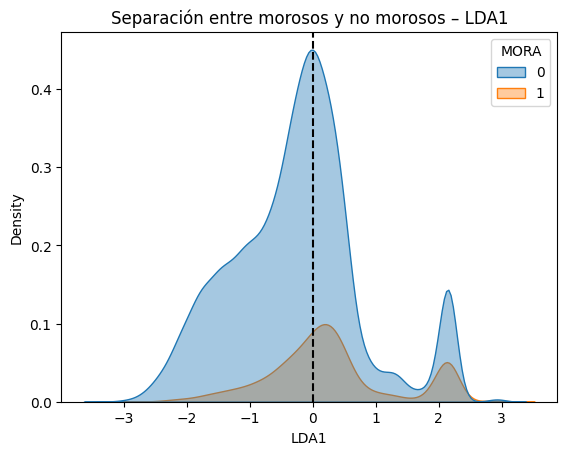

In [395]:
df_plot = pd.DataFrame({"LDA1": lda.transform(X)[:,0], "MORA": y})

sns.kdeplot(data=df_plot, x="LDA1", hue="MORA", fill=True, alpha=0.4)
plt.axvline(0, linestyle="--", color="black")
plt.title("Separación entre morosos y no morosos – LDA1")
plt.show()

Umbrales para LDA

In [396]:
y_proba_lda = lda.predict_proba(X)[:,1]

# Probando umbrales de 0.1 a 0.9
thresholds = [i/100 for i in range(5,95,5)]
resultados = []

for t in thresholds:
    y_pred_t = (y_proba_lda >= t).astype(int)
    resultados.append([
        t,
        precision_score(y, y_pred_t),
        recall_score(y, y_pred_t),
        f1_score(y, y_pred_t)
    ])

import pandas as pd
tabla_lda = pd.DataFrame(resultados, columns=["threshold","precision","recall","f1"])
print(tabla_lda)

    threshold  precision    recall        f1
0        0.05   0.157849  1.000000  0.272659
1        0.10   0.157849  1.000000  0.272659
2        0.15   0.157863  1.000000  0.272679
3        0.20   0.158536  0.999309  0.273657
4        0.25   0.162982  0.990736  0.279916
5        0.30   0.171399  0.968197  0.291240
6        0.35   0.180770  0.927821  0.302586
7        0.40   0.190472  0.867948  0.312390
8        0.45   0.202296  0.767699  0.320212
9        0.50   0.227479  0.602323  0.330238
10       0.55   0.247572  0.356056  0.292066
11       0.60   0.274731  0.218888  0.243651
12       0.65   0.288569  0.185702  0.225980
13       0.70   0.309105  0.165238  0.215354
14       0.75   0.313174  0.144635  0.197881
15       0.80   0.402597  0.004287  0.008483
16       0.85   0.000000  0.000000  0.000000
17       0.90   0.000000  0.000000  0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [397]:
# Probabilidades LDA ya entrenado
y_proba_lda = lda.predict_proba(X)[:,1]

# Cambiando treshold
threshold = 0.55
y_pred_045 = (y_proba_lda >= threshold).astype(int)

print(f"\n Resultados con Threshold = {threshold}")
print("Accuracy:", accuracy_score(y, y_pred_045))
print("\nClassification Report:\n", classification_report(y, y_pred_045))
print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred_045))


 Resultados con Threshold = 0.55
Accuracy: 0.7275405971712938

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83     38584
           1       0.25      0.36      0.29      7232

    accuracy                           0.73     45816
   macro avg       0.56      0.58      0.56     45816
weighted avg       0.77      0.73      0.75     45816


Confusion Matrix:
 [[30758  7826]
 [ 4657  2575]]


In [398]:
coef = pd.DataFrame({
    "Variable": variables_manova,
    "Peso_LDA": lda.coef_[0]
})

coef["|Peso|"] = coef["Peso_LDA"].abs()
coef.sort_values(by="|Peso|", ascending=False, inplace=True)

print("\n Ranking definitivo de variables LDA:\n")
print(coef.drop(columns="|Peso|"))


 Ranking definitivo de variables LDA:

               Variable      Peso_LDA
6                  TASA -6.093930e+00
7                 PLAZO  3.587493e-02
3      TIEMPO_ACTIVIDAD  4.490420e-03
5                  EDAD -4.477216e-03
4  TIEMPO_EN_RESIDENCIA  2.254906e-03
0                 SCORE -1.669316e-03
1        INGRESOS_FIJOS  2.164834e-11
2          CUOTAMENSUAL -8.774707e-18


XGBOOST

In [399]:
X = df[variables_manova]
y = df["MORA"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     11575
           1       0.46      0.02      0.03      2170

    accuracy                           0.84     13745
   macro avg       0.65      0.51      0.47     13745
weighted avg       0.78      0.84      0.77     13745

AUC: 0.6743195748026793


In [400]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
model.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [401]:
y_pred_bal = model.predict(X_test)
y_proba_bal = model.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\n Resultados XGBoost + SMOTE")
print(classification_report(y_test, y_pred_bal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("AUC:", roc_auc_score(y_test, y_proba_bal))


 Resultados XGBoost + SMOTE
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     11575
           1       0.32      0.14      0.19      2170

    accuracy                           0.82     13745
   macro avg       0.58      0.54      0.54     13745
weighted avg       0.77      0.82      0.79     13745

Confusion Matrix:
 [[10939   636]
 [ 1877   293]]
AUC: 0.6580944750226433


Seleccion del umbral

In [402]:
def evaluar_threshold_smote(thresholds, y_test, y_prob):
    resultados = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        resultados.append([
            t,
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred)
        ])
    return pd.DataFrame(resultados, columns=["threshold","precision","recall","f1"])


thresholds = np.arange(0.10, 0.91, 0.05)
tabla_t = evaluar_threshold_smote(thresholds, y_test, y_proba_bal)
print(tabla_t)

    threshold  precision    recall        f1
0        0.10   0.182633  0.919816  0.304756
1        0.15   0.202506  0.826728  0.325324
2        0.20   0.218369  0.702304  0.333151
3        0.25   0.230236  0.566359  0.327384
4        0.30   0.245790  0.450691  0.318101
5        0.35   0.262378  0.358986  0.303172
6        0.40   0.280000  0.270968  0.275410
7        0.45   0.303180  0.197696  0.239331
8        0.50   0.315393  0.135023  0.189093
9        0.55   0.325342  0.087558  0.137981
10       0.60   0.349570  0.056221  0.096864
11       0.65   0.319372  0.028111  0.051673
12       0.70   0.360465  0.014286  0.027482
13       0.75   0.342857  0.005530  0.010884
14       0.80   0.538462  0.003226  0.006413
15       0.85   0.500000  0.000461  0.000921
16       0.90   0.000000  0.000000  0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [403]:
threshold = 0.20
y_pred_thr = (y_proba_bal >= threshold).astype(int)

print(f"\n* Resultados con threshold = {threshold} *")
print("Accuracy:", accuracy_score(y_test, y_pred_thr))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_thr))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_thr))


* Resultados con threshold = 0.2 *
Accuracy: 0.5561295016369588

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.53      0.67     11575
           1       0.22      0.70      0.33      2170

    accuracy                           0.56     13745
   macro avg       0.56      0.62      0.50     13745
weighted avg       0.80      0.56      0.61     13745


Matriz de Confusión:
[[6120 5455]
 [ 646 1524]]


In [404]:
auc = roc_auc_score(y_test, y_proba_bal)
print(f"\nAUC ROC del modelo: {auc:.4f}")


AUC ROC del modelo: 0.6581


Kmeans

In [405]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [406]:
vars_segmento = [
    "SCORE","CUOTAMENSUAL","INGRESOS_FIJOS",
    "TIEMPO_ACTIVIDAD","TIEMPO_EN_RESIDENCIA",
    "EDAD","TASA","PLAZO"
]

X_seg = df[vars_segmento]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seg)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    print(f"k={k} → Silhouette={silhouette_score(X_pca, labels):.3f}")


k=2 → Silhouette=0.409
k=3 → Silhouette=0.462
k=4 → Silhouette=0.447
k=5 → Silhouette=0.397
k=6 → Silhouette=0.399


In [407]:
# Elegimos el mayor sil
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df["cluster_final"] = kmeans.fit_predict(X_pca)

In [408]:
cluster_summary = df.groupby("cluster_final")[vars_segmento].mean()
print(cluster_summary)

                    SCORE  CUOTAMENSUAL  INGRESOS_FIJOS  TIEMPO_ACTIVIDAD  \
cluster_final                                                               
0              555.305393  2.377058e+13    4.439692e+06          4.518723   
1              717.579630  2.584281e+13    1.223826e+07         16.196041   
2              723.301411  3.736375e+13    5.902236e+06          9.812108   

               TIEMPO_EN_RESIDENCIA       EDAD      TASA      PLAZO  
cluster_final                                                        
0                          7.889780  31.543705  0.021176  34.466156  
1                         14.215986  54.754175  0.020860  32.939979  
2                         10.431412  41.709469  0.005893  15.732414  


Tamaño de clusters

In [409]:
df["cluster_final"].value_counts()

,count
cluster_final,
0,23121
1,13412
2,9283


In [410]:
df.groupby("cluster_final")[vars_segmento].median()

,SCORE,CUOTAMENSUAL,INGRESOS_FIJOS,TIEMPO_ACTIVIDAD,TIEMPO_EN_RESIDENCIA,EDAD,TASA,PLAZO
cluster_final,,,,,,,,
0,632.0,142539.035619,3000000.0,4.0,5.0,29.0,2.041800e-02,36.0
1,735.5,189949.940662,4000000.0,19.0,16.0,55.0,2.041800e-02,36.0
2,726.0,214825.333333,4000000.0,8.0,8.5,40.0,1.000000e-09,12.0


In [411]:
df[vars_segmento+["cluster_final"]].groupby("cluster_final").describe()

SCORE                                                    \
                 count        mean         std  min    25%    50%    75%   
cluster_final                                                              
0              23121.0  555.305393  255.068971 -8.0  549.0  632.0  710.0   
1              13412.0  717.579630  143.401963 -5.0  657.0  735.5  801.0   
2               9283.0  723.301411  109.855927 -5.0  654.0  726.0  793.0   

                     CUOTAMENSUAL                ...      TASA            \
                 max        count          mean  ...       75%       max   
cluster_final                                    ...                       
0              999.0      23121.0  2.377058e+13  ...  0.022497  0.030853   
1              999.0      13412.0  2.584281e+13  ...  0.022497  0.030853   
2              999.0       9283.0  3.736375e+13  ...  0.019291  0.029046   

                 PLAZO                                                    
                 count       mean       std  min   25%   50%   75%   max  
cluster_final                                                             
0              23121.0  34.466156  7.877808  3.0  36.0  36.0  36.0  60.0  
1              13412.0  32.939979  9.467874  3.0  30.0  36.0  36.0  60.0  
2               9283.0  15.732414  8.251549  3.0   9.0  12.0  24.0  36.0  

[3 rows x 64 columns]

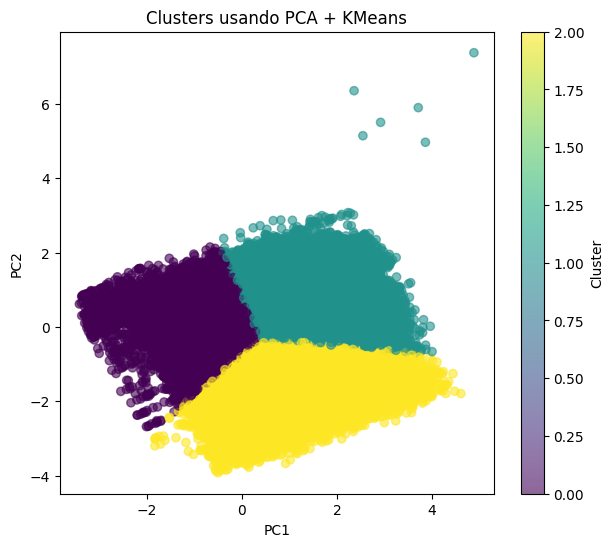

In [412]:
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster_final"], cmap="viridis", alpha=0.6)
plt.title("Clusters usando PCA + KMeans")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

In [413]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1','PC2'],
    index=vars_segmento
)
loadings

,PC1,PC2
SCORE,0.394226,-0.108339
CUOTAMENSUAL,0.003755,-0.005639
INGRESOS_FIJOS,0.022529,0.049937
TIEMPO_ACTIVIDAD,0.563232,0.259229
TIEMPO_EN_RESIDENCIA,0.315589,0.214788
EDAD,0.553678,0.253111
TASA,-0.245971,0.634295
PLAZO,-0.245309,0.637188


/tmp/ipython-input-1620874580.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0,0, loadings.PC1[i]*3, loadings.PC2[i]*3, color='red', width=0.01)
/tmp/ipython-input-1620874580.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings.PC1[i]*3.2, loadings.PC2[i]*3.2, var, color='red')


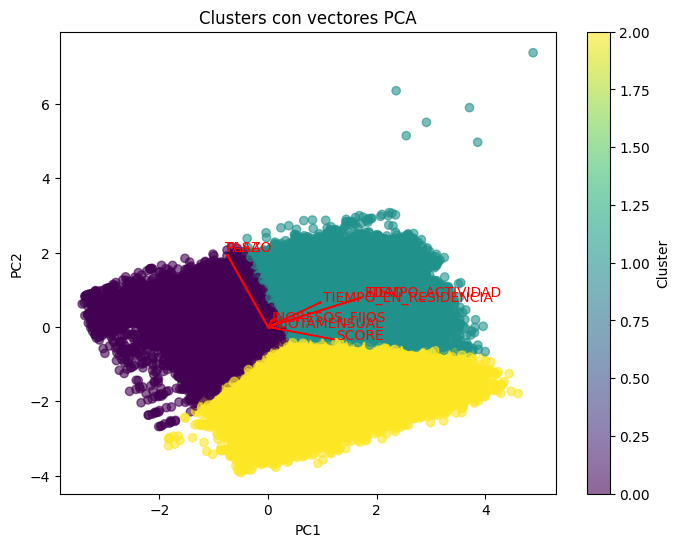

In [414]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster_final"], cmap="viridis", alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters con vectores PCA")

for i, var in enumerate(loadings.index):
    plt.arrow(0,0, loadings.PC1[i]*3, loadings.PC2[i]*3, color='red', width=0.01)
    plt.text(loadings.PC1[i]*3.2, loadings.PC2[i]*3.2, var, color='red')

plt.show()

Robustez

In [415]:

df_test = df.iloc[X_test.index].copy()

subgroups = {
    "Género": "GÉNERO",
    "Estrato": "ESTRATO",
    "Nivel de estudios": "NIVEL_ESTUDIOS",
}

for nombre, col in subgroups.items():
    print(f"\n= Robustez por {nombre} ({col}) =")
    for valor in sorted(df_test[col].unique()):
        mask = df_test[col] == valor
        if mask.sum() < 100:
            continue
        print(f"\nSubgrupo: {valor}  (n = {mask.sum()})")
        print(classification_report(y_test[mask], y_pred_thr[mask], digits=2))


= Robustez por Género (GÉNERO) =

Subgrupo: 0.0  (n = 5226)
              precision    recall  f1-score   support

           0       0.90      0.54      0.67      4342
           1       0.24      0.70      0.35       884

    accuracy                           0.56      5226
   macro avg       0.57      0.62      0.51      5226
weighted avg       0.79      0.56      0.62      5226


Subgrupo: 1.0  (n = 8184)
              precision    recall  f1-score   support

           0       0.91      0.53      0.67      6961
           1       0.21      0.70      0.32      1223

    accuracy                           0.56      8184
   macro avg       0.56      0.61      0.49      8184
weighted avg       0.80      0.56      0.62      8184


= Robustez por Estrato (ESTRATO) =

Subgrupo: 1  (n = 420)
              precision    recall  f1-score   support

           0       0.92      0.48      0.63       361
           1       0.19      0.75      0.30        59

    accuracy                      